In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
import seaborn as sns

In [2]:
df = pd.read_csv('/Users/anastasiaintyakova/Documents/labs/insurance_train.csv')
df_test = pd.read_csv('/Users/anastasiaintyakova/Documents/labs/insurance_test.csv')

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,26,male,27.060,0,yes,southeast,17043.34140
1,58,male,36.955,2,yes,northwest,47496.49445
2,20,female,24.420,0,yes,southeast,26125.67477
3,51,female,38.060,0,yes,southeast,44400.40640
4,62,female,25.000,0,no,southwest,13451.12200


In [4]:
df_test.head()

,age,sex,bmi,children,smoker,region,charges
0,61,male,38.380,0,no,northwest,12950.07120
1,59,female,34.800,2,no,southwest,36910.60803
2,31,male,30.875,0,no,northeast,3857.75925
3,24,female,33.345,0,no,northwest,2855.43755
4,31,male,28.500,5,no,northeast,6799.45800


In [5]:
print('\n---- Пропуски Train ----')
print(df.isnull().sum())
print('\n---- Пропуски Test ----')
print(df_test.isnull().sum())


---- Пропуски Train ----
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

---- Пропуски Test ----
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [6]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove('charges') 

outliers_info = {}
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    n_out = ((df[col] < lower) | (df[col] > upper)).sum()
    outliers_info[col] = {'lower': lower, 'upper': upper, 'n_outliers': int(n_out)}

print('\n--- Выбросы (IQR) ---')
for k, v in outliers_info.items():
    print(f"{k}: {v['n_outliers']} выбросов; границы [{v['lower']:.3f}, {v['upper']:.3f}]")


--- Выбросы (IQR) ---
age: 0 выбросов; границы [-7.500, 84.500]
bmi: 5 выбросов; границы [13.242, 47.407]
children: 0 выбросов; границы [-3.000, 5.000]


In [7]:
display(df.describe(include='all'))

,age,sex,bmi,children,smoker,region,charges
count,338.000000,338,338.000000,338.000000,338,338,338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,176,NaN,NaN,260,102,NaN
mean,38.810651,NaN,30.672751,1.153846,NaN,NaN,14092.861924
std,13.637734,NaN,6.309709,1.205822,NaN,NaN,12792.472722
min,18.000000,NaN,17.290000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.053750,0.000000,NaN,NaN,4811.304137
50%,38.000000,NaN,30.065000,1.000000,NaN,NaN,9891.530425
75%,50.000000,NaN,34.595000,2.000000,NaN,NaN,19423.699050


In [8]:
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')

In [9]:
df['sex_encoded'] = label_encoder.fit_transform(df['sex'])
df['smoker_encoded'] = label_encoder.fit_transform(df['smoker'])

df_test['sex_encoded'] = label_encoder.fit_transform(df_test['sex'])
df_test['smoker_encoded'] = label_encoder.fit_transform(df_test['smoker'])

In [10]:
df = df.drop(columns=['sex', 'smoker'])

df_test = df_test.drop(columns=['sex', 'smoker'])

In [11]:
ct = ColumnTransformer(
    transformers=[('encoder', one_hot_encoder, ['region'])],
    remainder='passthrough'
)

In [12]:
df_encoded = pd.get_dummies(df, columns=['region'], drop_first=True)

df_test_encoded = pd.get_dummies(df_test, columns=['region'], drop_first=True)

In [13]:
region_cols = [col for col in df_encoded.columns if col.startswith('region_')]
for col in region_cols:
    df_encoded[col] = df_encoded[col].astype(int)

region_cols = [col for col in df_test_encoded.columns if col.startswith('region_')]
for col in region_cols:
    df_test_encoded[col] = df_test_encoded[col].astype(int)

In [14]:
df_encoded.head()

,age,bmi,children,charges,sex_encoded,smoker_encoded,region_northwest,region_southeast,region_southwest
0,26,27.060,0,17043.34140,1,1,0,1,0
1,58,36.955,2,47496.49445,1,1,1,0,0
2,20,24.420,0,26125.67477,0,1,0,1,0
3,51,38.060,0,44400.40640,0,1,0,1,0
4,62,25.000,0,13451.12200,0,0,0,0,1


In [15]:
df_test_encoded.head()

,age,bmi,children,charges,sex_encoded,smoker_encoded,region_northwest,region_southeast,region_southwest
0,61,38.380,0,12950.07120,1,0,1,0,0
1,59,34.800,2,36910.60803,0,0,0,0,1
2,31,30.875,0,3857.75925,1,0,0,0,0
3,24,33.345,0,2855.43755,0,0,1,0,0
4,31,28.500,5,6799.45800,1,0,0,0,0


In [16]:
print('\n---- Train ----')
display(df_encoded.describe(include='all'))
print('\n---- Test ----')
display(df_test_encoded.describe(include='all'))


---- Train ----


,age,bmi,children,charges,sex_encoded,smoker_encoded,region_northwest,region_southeast,region_southwest
count,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000
mean,38.810651,30.672751,1.153846,14092.861924,0.520710,0.230769,0.236686,0.301775,0.224852
std,13.637734,6.309709,1.205822,12792.472722,0.500312,0.421950,0.425678,0.459709,0.418104
min,18.000000,17.290000,0.000000,1121.873900,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,26.053750,0.000000,4811.304137,0.000000,0.000000,0.000000,0.000000,0.000000
50%,38.000000,30.065000,1.000000,9891.530425,1.000000,0.000000,0.000000,0.000000,0.000000
75%,50.000000,34.595000,2.000000,19423.699050,1.000000,0.000000,0.000000,1.000000,0.000000
max,64.000000,53.130000,5.000000,63770.428010,1.000000,1.000000,1.000000,1.000000,1.000000



---- Test ----


,age,bmi,children,charges,sex_encoded,smoker_encoded,region_northwest,region_southeast,region_southwest
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000
mean,39.341000,30.660235,1.075000,12992.437660,0.50000,0.196000,0.245000,0.262000,0.24900
std,14.190775,6.028243,1.205333,11864.228619,0.50025,0.397167,0.430302,0.439943,0.43265
min,18.000000,15.960000,0.000000,1135.940700,0.00000,0.000000,0.000000,0.000000,0.00000
25%,26.000000,26.400000,0.000000,4683.139575,0.00000,0.000000,0.000000,0.000000,0.00000
50%,40.000000,30.495000,1.000000,9237.375800,0.50000,0.000000,0.000000,0.000000,0.00000
75%,52.000000,34.700000,2.000000,15262.519162,1.00000,0.000000,0.000000,1.000000,0.00000
max,64.000000,52.580000,5.000000,62592.873090,1.00000,1.000000,1.000000,1.000000,1.00000


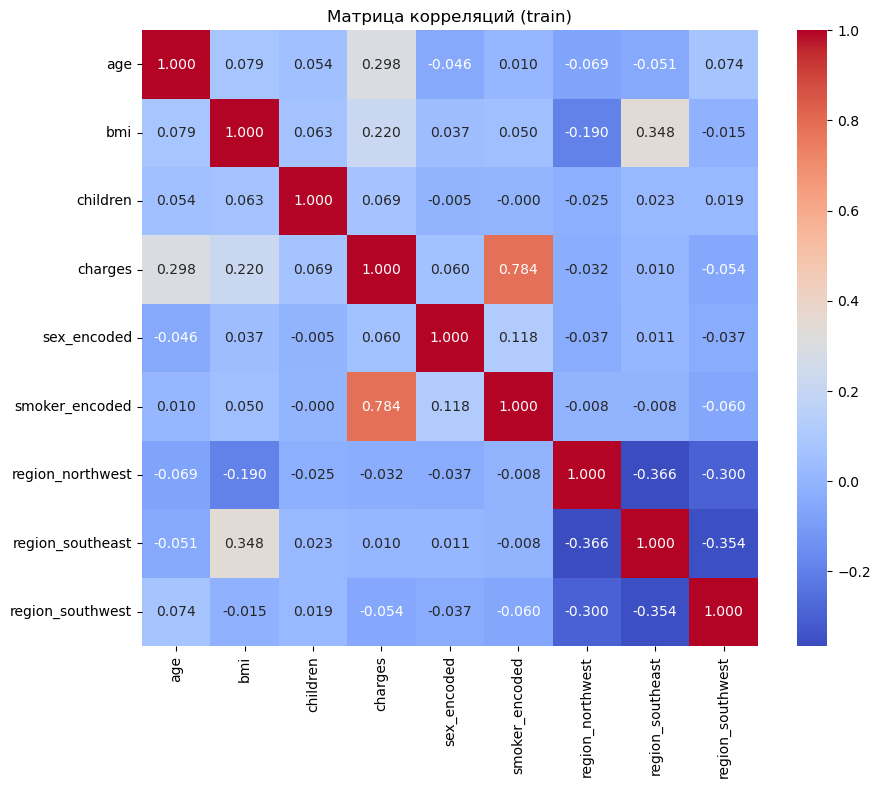

In [17]:
plt.figure(figsize=(10,8))
sns.heatmap(df_encoded.corr(), annot=True, fmt='.3f', cmap='coolwarm', square=True)
plt.title('Матрица корреляций (train)')
plt.show()

In [18]:
X_train_raw = df_encoded.drop(columns=['charges']).copy()
y_train = df_encoded['charges'].values

X_test_raw = df_test_encoded.drop(columns=['charges']).copy()
y_test = df_test_encoded['charges'].values

In [19]:
numerical_cols = ['age', 'bmi', 'children']
scaler = StandardScaler()
X_train_raw[numerical_cols] = scaler.fit_transform(X_train_raw[numerical_cols])
X_test_raw[numerical_cols] = scaler.transform(X_test_raw[numerical_cols])

In [20]:
X_train = np.hstack([np.ones((X_train_raw.shape[0], 1)), X_train_raw.values])
X_test = np.hstack([np.ones((X_test_raw.shape[0], 1)), X_test_raw.values])

m_train, n_features = X_train.shape

In [21]:
def analytical_linear_regression(X, y):
    return np.linalg.pinv(X.T @ X) @ X.T @ y

In [22]:
w_lin_analytical = analytical_linear_regression(X_train, y_train)

In [23]:
learning_rate = 0.01
n_iterations = 2000

In [24]:
def gradient_descent(X, y, learning_rate, n_iterations):
    m = X.shape[0]
    w = np.zeros(X.shape[1])
    for _ in range(n_iterations):
        predictions = X @ w
        errors = predictions - y
        gradient = (2/m) * (X.T @ errors)
        w = w - learning_rate * gradient
    return w

In [25]:
w_lin_gd = gradient_descent(X_train, y_train, learning_rate, n_iterations)

In [26]:
lambda_reg = 1000 

In [27]:
def analytical_ridge_regression(X, y, lambda_reg):
    m, n = X.shape
    I = np.identity(n)
    I[0, 0] = 0 
    return np.linalg.pinv(X.T @ X + lambda_reg * I) @ X.T @ y

In [28]:
w_ridge_analytical = analytical_ridge_regression(X_train, y_train, lambda_reg)

In [29]:
def regularized_gradient_descent(X, y, learning_rate, n_iterations, lambda_reg):
    m = X.shape[0]
    w = np.zeros(X.shape[1])
    for _ in range(n_iterations):
        predictions = X @ w
        errors = predictions - y
        
        w_temp = w.copy()
        w_temp[0] = 0 

        gradient_regularization = (2 * lambda_reg / m) * w_temp
        gradient = (2/m) * (X.T @ errors) + gradient_regularization
        
        w = w - learning_rate * gradient
    return w

In [30]:
w_ridge_gd = regularized_gradient_descent(X_train, y_train, learning_rate, n_iterations, lambda_reg)

In [31]:
y_pred_constant = np.full_like(y_test, y_train.mean())
mse_constant = mean_squared_error(y_test, y_pred_constant)

In [32]:
y_pred_lin_analytical = X_test @ w_lin_analytical
mse_lin_analytical = mean_squared_error(y_test, y_pred_lin_analytical)

In [33]:
y_pred_lin_gd = X_test @ w_lin_gd
mse_lin_gd = mean_squared_error(y_test, y_pred_lin_gd)

In [34]:
y_pred_ridge_analytical = X_test @ w_ridge_analytical
mse_ridge_analytical = mean_squared_error(y_test, y_pred_ridge_analytical)

In [35]:
y_pred_ridge_gd = X_test @ w_ridge_gd
mse_ridge_gd = mean_squared_error(y_test, y_pred_ridge_gd)

In [36]:
results = {
    'Constant (Train Mean)': mse_constant,
    'Linear (Analytical)': mse_lin_analytical,
    'Linear (Numerical GD)': mse_lin_gd,
    f'Ridge (Analytical, $\lambda={lambda_reg}$)': mse_ridge_analytical,
    f'Ridge (Numerical GD, $\lambda={lambda_reg}$)': mse_ridge_gd
}

In [37]:
results_df = pd.DataFrame(results.items(), columns=['Model', 'MSE'])
results_df['RMSE'] = np.sqrt(results_df['MSE'])
results_df = results_df.sort_values(by='MSE')

In [38]:
feature_names = ['Intercept'] + list(X_train_raw.columns)

In [42]:
weights_df = pd.DataFrame({
    'Feature': feature_names,
    'Linear (Analytical)': w_lin_analytical.flatten(),
    f'Ridge (λ={lambda_reg})': w_ridge_analytical.flatten()
})

weights_df = weights_df.round(4)

weights_df = weights_df.reindex(weights_df['Linear (Analytical)'].abs().sort_values(ascending=False).index)

weights_df.style \
    .background_gradient(cmap='RdYlBu', subset=['Linear (Analytical)', f'Ridge (λ={lambda_reg})']) \
    .format({'Linear (Analytical)': '{:.4f}', f'Ridge (λ={lambda_reg})': '{:.4f}'}) \
    .set_caption("Сводка весов моделей (w)") \
    .set_properties(**{'text-align': 'center'}) \
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'th', 'props': [('background-color', '#f2f2f2'), ('text-align', 'center')]}
    ])

,Feature,Linear (Analytical),Ridge (λ=1000)
5,smoker_encoded,23401.9926,1337.5381
0,Intercept,9824.4914,13758.0485
1,age,3495.7695,946.2366
2,bmi,2210.5718,678.5141
8,region_southwest,-1440.5076,-96.2470
7,region_southeast,-1389.8957,-11.8938
4,sex_encoded,-655.4050,112.2301
3,children,581.6751,200.6054
6,region_northwest,-200.5870,-29.8198


In [41]:
results_df = results_df.sort_values(by='MSE', ascending=True)

def highlight_min_mse(s):
    is_min = s == s.min()
    return ['background-color: lightgreen' if v else '' for v in is_min]

styled_results_df = results_df.style \
    .apply(highlight_min_mse, subset=['MSE'], axis=0) \
    .format({'MSE': '{:,.2f}', 'RMSE': '{:,.2f}'}) \
    .set_caption("Сравнение моделей по MSE и RMSE на тестовых данных") \
    .set_properties(**{'text-align': 'center'}) \
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold'), ('text-align', 'center')]},
        {'selector': 'th', 'props': [('background-color', '#f2f2f2'), ('text-align', 'center')]}
    ])

display(styled_results_df)

print(f"\nНаилучшая модель (минимальный MSE): {results_df.iloc[0]['Model']}")

,Model,MSE,RMSE
2,Linear (Numerical GD),"34,156,143.51","5,844.33"
1,Linear (Analytical),"34,216,008.76","5,849.45"
4,"Ridge (Numerical GD, $\lambda=1000$)","123,297,286.80","11,103.93"
3,"Ridge (Analytical, $\lambda=1000$)","123,297,286.80","11,103.93"
0,Constant (Train Mean),"141,830,094.36","11,909.24"



Наилучшая модель (минимальный MSE): Linear (Numerical GD)
